# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [2]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Formative 2/malaria-diagnosis/"

Mounted at /content/drive/


In [3]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Populating namespaces

In [4]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [5]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Formative 2/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [6]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Formative 2/malaria-diagnosis/"
    !unzip "/content/drive/My Drive/Formative 2/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Formative 2/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Formative 2/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 12:16:35--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.167.192.111, 3.167.192.56, 3.167.192.32, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.167.192.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M   207MB/s    in 1.6s    

2025-10-05 12:16:36 (207 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  drive  sample_data  test	train


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


#**BASELINE CNN MODEL FOR MALARIA DIAGNOSIS**
### Author: Edine Noella Mugisha
### Model: Simple Baseline CNN

## Section 1: Data Preparation And Exploration
This section handles dataset splitting, visualization, and preprocessing



In [7]:
import os
import random
import shutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.image import imread
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

print("=" * 80)
print("BASELINE CNN MODEL - DATA PREPARATION")
print("=" * 80)

# ============================================================================
# 1.1 CREATE TRAIN/TEST SPLIT
# ============================================================================

def create_train_test_split(source_dir, train_dir, test_dir, split_ratio=0.8):
    """
    Splits the dataset into training and testing sets.

    Args:
        source_dir: Directory containing cell_images folder
        train_dir: Destination directory for training data
        test_dir: Destination directory for testing data
        split_ratio: Proportion of data for training (default: 0.8)
    """

    # Remove existing directories if they exist
    if os.path.exists(train_dir):
        shutil.rmtree(train_dir)
    if os.path.exists(test_dir):
        shutil.rmtree(test_dir)

    # Create fresh directories
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Process each class (Parasitized and Uninfected)
    classes = ['Parasitized', 'Uninfected']

    for class_name in classes:
        # Create class subdirectories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Get all images for this class
        class_dir = os.path.join(source_dir, class_name)
        images = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

        # Shuffle images
        random.shuffle(images)

        # Calculate split point
        split_point = int(len(images) * split_ratio)

        # Split into train and test
        train_images = images[:split_point]
        test_images = images[split_point:]

        # Copy images to respective directories
        print(f"\nProcessing {class_name}:")
        print(f"  Total images: {len(images)}")
        print(f"  Training: {len(train_images)}")
        print(f"  Testing: {len(test_images)}")

        for img in train_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(train_dir, class_name, img)
            shutil.copy2(src, dst)

        for img in test_images:
            src = os.path.join(class_dir, img)
            dst = os.path.join(test_dir, class_name, img)
            shutil.copy2(src, dst)

    print("\n" + "=" * 80)
    print("Data split completed successfully!")
    print("=" * 80)

# Execute the split
cell_images_dir = 'cell_images'
training_path = 'train'
testing_path = 'test'

create_train_test_split(cell_images_dir, training_path, testing_path, split_ratio=0.8)



BASELINE CNN MODEL - DATA PREPARATION

Processing Parasitized:
  Total images: 13779
  Training: 11023
  Testing: 2756

Processing Uninfected:
  Total images: 13779
  Training: 11023
  Testing: 2756

Data split completed successfully!



EXPLORATORY DATA ANALYSIS


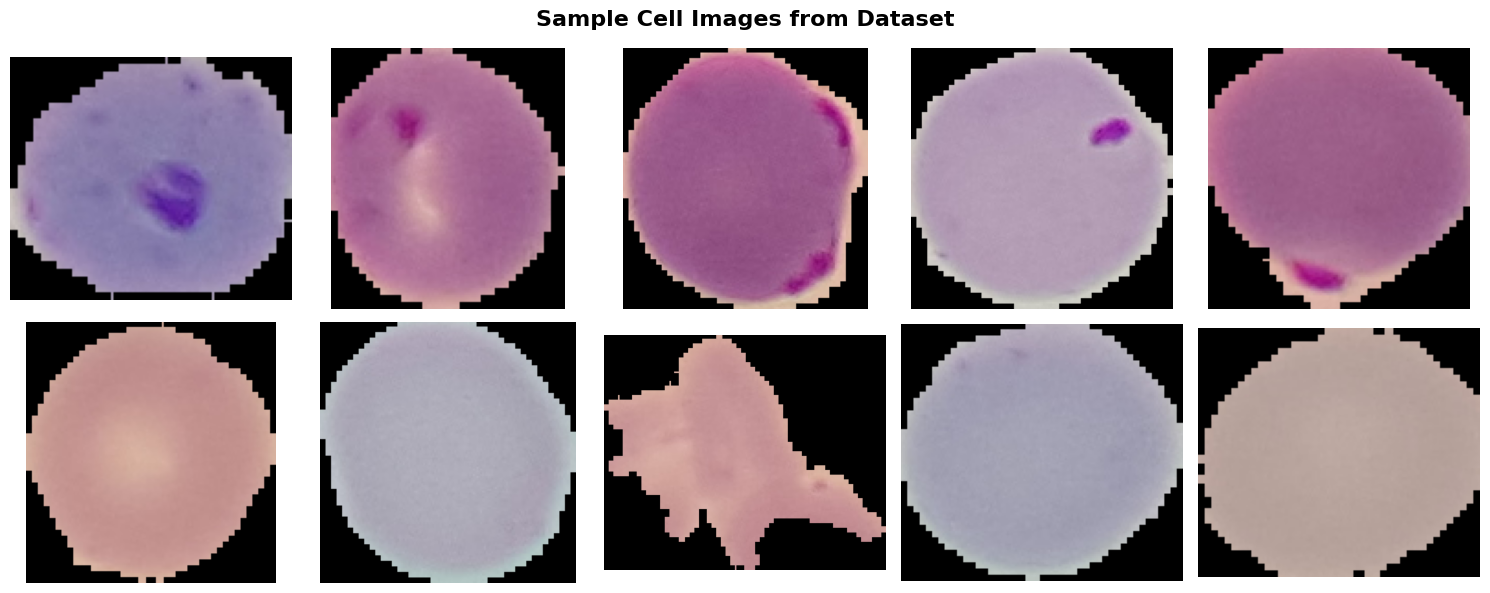

In [8]:
# ============================================================================
# 1.2 EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n" + "=" * 80)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 80)

def visualize_sample_images(data_dir, num_samples=5):
    """
    Visualize sample images from each class.
    """
    classes = ['Parasitized', 'Uninfected']

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle('Sample Cell Images from Dataset', fontsize=16, fontweight='bold')

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        images = random.sample(os.listdir(class_dir), num_samples)

        for j, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            img = imread(img_path)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(class_name, fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Visualize samples
visualize_sample_images(training_path)


Image Dimension Statistics:
--------------------------------------------------------------------------------
            height        width  channels
count  2000.000000  2000.000000    2000.0
mean    133.402000   132.421000       3.0
std      20.651408    20.199029       0.0
min      58.000000    64.000000       3.0
25%     121.000000   121.000000       3.0
50%     133.000000   130.000000       3.0
75%     145.000000   142.000000       3.0
max     382.000000   259.000000       3.0


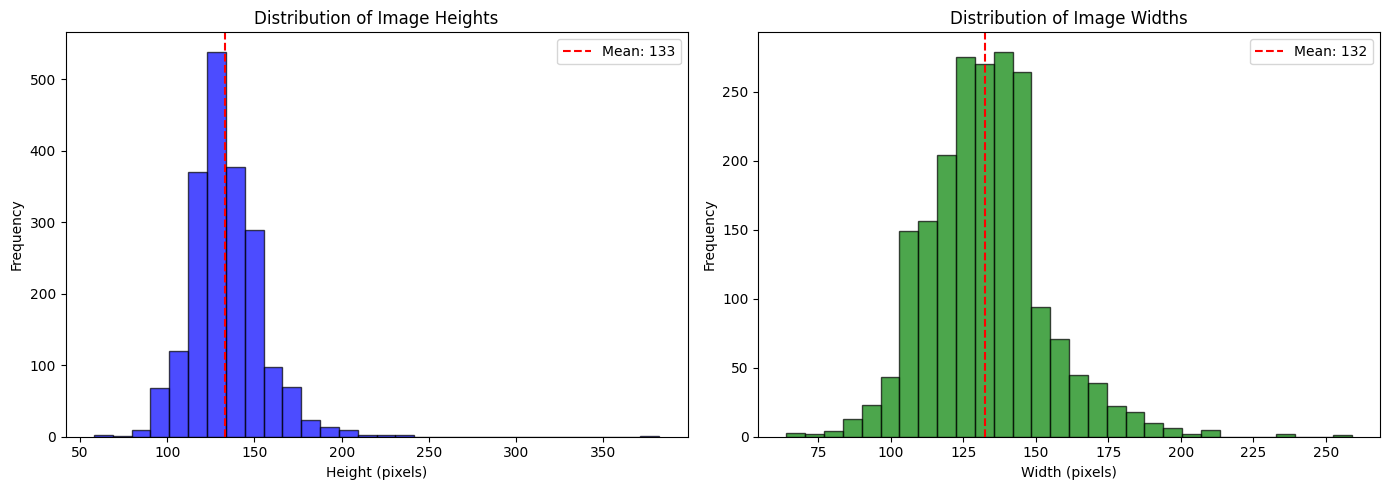

In [9]:
# ============================================================================
# 1.3 ANALYZE IMAGE DIMENSIONS
# ============================================================================

def analyze_image_dimensions(data_dir, sample_size=1000):
    """
    Analyze the dimensions of images in the dataset.
    """
    classes = ['Parasitized', 'Uninfected']
    dimensions = []

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        images = os.listdir(class_dir)
        sampled_images = random.sample(images, min(sample_size, len(images)))

        for img_name in sampled_images:
            img_path = os.path.join(class_dir, img_name)
            img = imread(img_path)
            dimensions.append({
                'class': class_name,
                'height': img.shape[0],
                'width': img.shape[1],
                'channels': img.shape[2] if len(img.shape) > 2 else 1
            })

    df_dims = pd.DataFrame(dimensions)

    print("\nImage Dimension Statistics:")
    print("-" * 80)
    print(df_dims.describe())

    # Visualize dimensions distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(df_dims['height'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_xlabel('Height (pixels)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Image Heights')
    axes[0].axvline(df_dims['height'].mean(), color='red', linestyle='--',
                    label=f'Mean: {df_dims["height"].mean():.0f}')
    axes[0].legend()

    axes[1].hist(df_dims['width'], bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_xlabel('Width (pixels)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Image Widths')
    axes[1].axvline(df_dims['width'].mean(), color='red', linestyle='--',
                    label=f'Mean: {df_dims["width"].mean():.0f}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return df_dims

df_dimensions = analyze_image_dimensions(training_path)

## Section 2: Data Preprocessing And Augmentation

In [10]:
# ============================================================================
# SECTION 2: DATA PREPROCESSING AND AUGMENTATION
# ============================================================================

print("\n" + "=" * 80)
print("DATA PREPROCESSING AND AUGMENTATION")
print("=" * 80)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
BATCH_SIZE = 32

# ============================================================================
# 2.1 CREATE DATA GENERATORS
# ============================================================================

# Training data generator with normalization (NO augmentation for baseline)
# We only rescale pixel values to [0, 1] range
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% of training data for validation
)

# Test data generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    testing_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("\nData Generators Created:")
print(f"  Training samples: {train_generator.samples}")
print(f"  Validation samples: {validation_generator.samples}")
print(f"  Test samples: {test_generator.samples}")
print(f"  Class indices: {train_generator.class_indices}")


DATA PREPROCESSING AND AUGMENTATION
Found 17638 images belonging to 2 classes.
Found 4408 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.

Data Generators Created:
  Training samples: 17638
  Validation samples: 4408
  Test samples: 5512
  Class indices: {'Parasitized': 0, 'Uninfected': 1}


## SECTION 3: Baseline CNN Model Architecture

In [11]:
# ============================================================================
# SECTION 3: BASELINE CNN MODEL ARCHITECTURE
# ============================================================================

print("\n" + "=" * 80)
print("BASELINE CNN MODEL ARCHITECTURE")
print("=" * 80)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_baseline_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    """
    Creates a simple baseline CNN architecture.

    Architecture:
    - Conv2D (32 filters, 3x3) + ReLU + MaxPooling
    - Conv2D (64 filters, 3x3) + ReLU + MaxPooling
    - Conv2D (64 filters, 3x3) + ReLU + MaxPooling
    - Flatten
    - Dense (128 units) + ReLU
    - Dropout (0.5)
    - Dense (1 unit) + Sigmoid (binary classification)
    """

    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv1'),
        MaxPooling2D(pool_size=(2, 2), name='pool1'),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', name='conv2'),
        MaxPooling2D(pool_size=(2, 2), name='pool2'),

        # Third Convolutional Block
        Conv2D(64, (3, 3), activation='relu', name='conv3'),
        MaxPooling2D(pool_size=(2, 2), name='pool3'),

        # Flatten and Dense Layers
        Flatten(name='flatten'),
        Dense(128, activation='relu', name='dense1'),
        Dropout(0.5, name='dropout'),
        Dense(1, activation='sigmoid', name='output')
    ])

    return model

# Create the baseline model
baseline_model = create_baseline_cnn()

# Display model architecture
print("\nModel Architecture Summary:")
print("-" * 80)
baseline_model.summary()

# ============================================================================
# 3.1 COMPILE THE MODEL
# ============================================================================

baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

print("\nModel compiled successfully!")
print("  Optimizer: Adam (lr=0.001)")
print("  Loss: Binary Crossentropy")
print("  Metrics: Accuracy, Precision, Recall, AUC")


BASELINE CNN MODEL ARCHITECTURE


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Model Architecture Summary:
--------------------------------------------------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,662,209 (6.34 MB)

 Trainable params: 1,662,209 (6.34 MB)

 Non-trainable params: 0 (0.00 B)


Model compiled successfully!
  Optimizer: Adam (lr=0.001)
  Loss: Binary Crossentropy
  Metrics: Accuracy, Precision, Recall, AUC


## Section 4: Training The Model (7 Experiments)

In [12]:
# ============================================================================
# SECTION 4: TRAINING THE MODEL (7 EXPERIMENTS)
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT TRACKING")
print("=" * 80)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Store results for all experiments
experiment_results = []

# ============================================================================
# EXPERIMENT 1: BASELINE (10 epochs, batch_size=32, lr=0.001)
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 1: Baseline Configuration")
print("  Epochs: 10, Batch Size: 32, Learning Rate: 0.001")
print("=" * 80)

# Callbacks
callbacks_exp1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('baseline_exp1_best.h5', monitor='val_accuracy',
                   save_best_only=True, verbose=1)
]

history_exp1 = baseline_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks_exp1,
    verbose=1
)

# Evaluate on test set
test_results_exp1 = baseline_model.evaluate(test_generator, verbose=1)

experiment_results.append({
    'Experiment': 1,
    'Description': 'Baseline (10 epochs, bs=32, lr=0.001)',
    'Test Loss': test_results_exp1[0],
    'Test Accuracy': test_results_exp1[1],
    'Test Precision': test_results_exp1[2],
    'Test Recall': test_results_exp1[3],
    'Test AUC': test_results_exp1[4]
})


EXPERIMENT TRACKING

EXPERIMENT 1: Baseline Configuration
  Epochs: 10, Batch Size: 32, Learning Rate: 0.001
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6754 - auc: 0.7366 - loss: 0.5847 - precision: 0.6700 - recall: 0.6803
Epoch 1: val_accuracy improved from -inf to 0.92672, saving model to baseline_exp1_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.6757 - auc: 0.7369 - loss: 0.5844 - precision: 0.6702 - recall: 0.6805 - val_accuracy: 0.9267 - val_auc: 0.9719 - val_loss: 0.2276 - val_precision: 0.9246 - val_recall: 0.9292
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9336 - auc: 0.9731 - loss: 0.1988 - precision: 0.9288 - recall: 0.9394
Epoch 2: val_accuracy improved from 0.92672 to 0.93875, saving model to baseline_exp1_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - accuracy: 0.9336 - auc: 0.9731 - loss: 0.1988 - precision: 0.9288 - recall: 0.9394 - val_accuracy: 0.9387 - val_auc: 0.9813 - val_loss: 0.1696 - val_precision: 0.9452 - val_recall: 0.9315
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9530 - auc: 0.9804 - loss: 0.1549 - precision: 0.9399 - recall: 0.9677
Epoch 3: val_accuracy improved from 0.93875 to 0.94397, saving model to baseline_exp1_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 45s 56ms/step - accuracy: 0.9530 - auc: 0.9804 - loss: 0.1549 - precision: 0.9399 - recall: 0.9677 - val_accuracy: 0.9440 - val_auc: 0.9846 - val_loss: 0.1612 - val_precision: 0.9256 - val_recall: 0.9655
Epoch 4/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9598 - auc: 0.9861 - loss: 0.1297 - precision: 0.9496 - recall: 0.9725
Epoch 4: val_accuracy improved from 0.94397 to 0.94510, saving model to baseline_exp1_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.9598 - auc: 0.9861 - loss: 0.1297 - precision: 0.9496 - recall: 0.9725 - val_accuracy: 0.9451 - val_auc: 0.9795 - val_loss: 0.1784 - val_precision: 0.9329 - val_recall: 0.9592
Epoch 5/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9648 - auc: 0.9899 - loss: 0.1147 - precision: 0.9557 - recall: 0.9744
Epoch 5: val_accuracy did not improve from 0.94510
552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - accuracy: 0.9648 - auc: 0.9899 - loss: 0.1147 - precision: 0.9557 - recall: 0.9744 - val_accuracy: 0.9446 - val_auc: 0.9826 - val_loss: 0.1715 - val_precision: 0.9442 - val_recall: 0.9451
Epoch 6/10
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9660 - auc: 0.9909 - loss: 0.1051 - precision: 0.9578 - recall: 0.9744
Epoch 6: val_accuracy did not improve from 0.94510
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.9660 - auc: 0.9909 - loss: 0.1051 - precision: 0.9578 - recall: 0.9744 - val_accuracy: 0.9449 - val

552/552 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - accuracy: 0.9725 - auc: 0.9942 - loss: 0.0841 - precision: 0.9684 - recall: 0.9771 - val_accuracy: 0.9480 - val_auc: 0.9821 - val_loss: 0.1726 - val_precision: 0.9426 - val_recall: 0.9542
Epoch 8/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9770 - auc: 0.9962 - loss: 0.0693 - precision: 0.9731 - recall: 0.9816
Epoch 8: val_accuracy did not improve from 0.94805
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9769 - auc: 0.9962 - loss: 0.0693 - precision: 0.9731 - recall: 0.9816 - val_accuracy: 0.9415 - val_auc: 0.9763 - val_loss: 0.2076 - val_precision: 0.9352 - val_recall: 0.9487
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9392 - auc: 0.4992 - loss: 0.1533 - precision: 0.4184 - recall: 0.4907


In [13]:
# ============================================================================
# EXPERIMENT 2: Increased Epochs (20 epochs)
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 2: Increased Training Duration")
print("  Epochs: 20, Batch Size: 32, Learning Rate: 0.001")
print("=" * 80)

# Reset model
baseline_model_exp2 = create_baseline_cnn()
baseline_model_exp2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

callbacks_exp2 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint('baseline_exp2_best.h5', monitor='val_accuracy',
                   save_best_only=True, verbose=1)
]

history_exp2 = baseline_model_exp2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks_exp2,
    verbose=1
)

test_results_exp2 = baseline_model_exp2.evaluate(test_generator, verbose=1)

experiment_results.append({
    'Experiment': 2,
    'Description': 'Increased epochs (20, bs=32, lr=0.001)',
    'Test Loss': test_results_exp2[0],
    'Test Accuracy': test_results_exp2[1],
    'Test Precision': test_results_exp2[2],
    'Test Recall': test_results_exp2[3],
    'Test AUC': test_results_exp2[4]
})


EXPERIMENT 2: Increased Training Duration
  Epochs: 20, Batch Size: 32, Learning Rate: 0.001
Epoch 1/20
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7660 - auc: 0.8366 - loss: 0.4799 - precision: 0.7560 - recall: 0.7898
Epoch 1: val_accuracy improved from -inf to 0.93262, saving model to baseline_exp2_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.7664 - auc: 0.8369 - loss: 0.4793 - precision: 0.7563 - recall: 0.7902 - val_accuracy: 0.9326 - val_auc: 0.9833 - val_loss: 0.1875 - val_precision: 0.9690 - val_recall: 0.8938
Epoch 2/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9448 - auc: 0.9793 - loss: 0.1659 - precision: 0.9380 - recall: 0.9530
Epoch 2: val_accuracy improved from 0.93262 to 0.93829, saving model to baseline_exp2_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9448 - auc: 0.9793 - loss: 0.1658 - precision: 0.9380 - recall: 0.9530 - val_accuracy: 0.9383 - val_auc: 0.9792 - val_loss: 0.1810 - val_precision: 0.9182 - val_recall: 0.9623
Epoch 3/20
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9578 - auc: 0.9856 - loss: 0.1359 - precision: 0.9477 - recall: 0.9696
Epoch 3: val_accuracy improved from 0.93829 to 0.94465, saving model to baseline_exp2_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9578 - auc: 0.9856 - loss: 0.1358 - precision: 0.9477 - recall: 0.9696 - val_accuracy: 0.9446 - val_auc: 0.9846 - val_loss: 0.1601 - val_precision: 0.9302 - val_recall: 0.9614
Epoch 4/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9653 - auc: 0.9898 - loss: 0.1130 - precision: 0.9560 - recall: 0.9754
Epoch 4: val_accuracy did not improve from 0.94465
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9653 - auc: 0.9898 - loss: 0.1130 - precision: 0.9560 - recall: 0.9754 - val_accuracy: 0.9433 - val_auc: 0.9782 - val_loss: 0.1894 - val_precision: 0.9335 - val_recall: 0.9546
Epoch 5/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9634 - auc: 0.9913 - loss: 0.1073 - precision: 0.9560 - recall: 0.9715
Epoch 5: val_accuracy did not improve from 0.94465
552/552 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - accuracy: 0.9634 - auc: 0.9913 - loss: 0.1073 - precision: 0.9560 - recall: 0.9715 - val_accuracy: 0.9444 - val

552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.9686 - auc: 0.9930 - loss: 0.0942 - precision: 0.9612 - recall: 0.9765 - val_accuracy: 0.9476 - val_auc: 0.9810 - val_loss: 0.1778 - val_precision: 0.9310 - val_recall: 0.9669
Epoch 7/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9739 - auc: 0.9950 - loss: 0.0773 - precision: 0.9677 - recall: 0.9799
Epoch 7: val_accuracy did not improve from 0.94760
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9739 - auc: 0.9950 - loss: 0.0773 - precision: 0.9677 - recall: 0.9799 - val_accuracy: 0.9453 - val_auc: 0.9821 - val_loss: 0.1840 - val_precision: 0.9360 - val_recall: 0.9560
Epoch 8/20
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9769 - auc: 0.9965 - loss: 0.0666 - precision: 0.9706 - recall: 0.9833
Epoch 8: val_accuracy did not improve from 0.94760
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.9769 - auc: 0.9965 - loss: 0.0666 - precision: 0.9706 - recall: 0.9833 - val_accuracy: 0.9460 - val

In [14]:
# ============================================================================
# EXPERIMENT 3: Lower Learning Rate (lr=0.0001)
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 3: Lower Learning Rate")
print("  Epochs: 15, Batch Size: 32, Learning Rate: 0.0001")
print("=" * 80)

baseline_model_exp3 = create_baseline_cnn()
baseline_model_exp3.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

callbacks_exp3 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint('baseline_exp3_best.h5', monitor='val_accuracy',
                   save_best_only=True, verbose=1)
]

history_exp3 = baseline_model_exp3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=callbacks_exp3,
    verbose=1
)

test_results_exp3 = baseline_model_exp3.evaluate(test_generator, verbose=1)

experiment_results.append({
    'Experiment': 3,
    'Description': 'Lower LR (15 epochs, bs=32, lr=0.0001)',
    'Test Loss': test_results_exp3[0],
    'Test Accuracy': test_results_exp3[1],
    'Test Precision': test_results_exp3[2],
    'Test Recall': test_results_exp3[3],
    'Test AUC': test_results_exp3[4]
})


EXPERIMENT 3: Lower Learning Rate
  Epochs: 15, Batch Size: 32, Learning Rate: 0.0001
Epoch 1/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6175 - auc: 0.6646 - loss: 0.6490 - precision: 0.6157 - recall: 0.6240
Epoch 1: val_accuracy improved from -inf to 0.75181, saving model to baseline_exp3_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.6175 - auc: 0.6647 - loss: 0.6489 - precision: 0.6158 - recall: 0.6241 - val_accuracy: 0.7518 - val_auc: 0.8228 - val_loss: 0.5540 - val_precision: 0.7684 - val_recall: 0.7210
Epoch 2/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7120 - auc: 0.7839 - loss: 0.5680 - precision: 0.7137 - recall: 0.7190
Epoch 2: val_accuracy improved from 0.75181 to 0.84846, saving model to baseline_exp3_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.7121 - auc: 0.7840 - loss: 0.5679 - precision: 0.7137 - recall: 0.7191 - val_accuracy: 0.8485 - val_auc: 0.9199 - val_loss: 0.4086 - val_precision: 0.8288 - val_recall: 0.8784
Epoch 3/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8471 - auc: 0.9254 - loss: 0.3704 - precision: 0.8496 - recall: 0.8388
Epoch 3: val_accuracy improved from 0.84846 to 0.91583, saving model to baseline_exp3_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.8472 - auc: 0.9254 - loss: 0.3704 - precision: 0.8497 - recall: 0.8389 - val_accuracy: 0.9158 - val_auc: 0.9743 - val_loss: 0.2158 - val_precision: 0.9265 - val_recall: 0.9034
Epoch 4/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9118 - auc: 0.9668 - loss: 0.2340 - precision: 0.9202 - recall: 0.9030
Epoch 4: val_accuracy improved from 0.91583 to 0.92854, saving model to baseline_exp3_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9118 - auc: 0.9668 - loss: 0.2339 - precision: 0.9202 - recall: 0.9030 - val_accuracy: 0.9285 - val_auc: 0.9782 - val_loss: 0.1982 - val_precision: 0.9487 - val_recall: 0.9061
Epoch 5/15
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9316 - auc: 0.9750 - loss: 0.1935 - precision: 0.9400 - recall: 0.9227
Epoch 5: val_accuracy improved from 0.92854 to 0.93149, saving model to baseline_exp3_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - accuracy: 0.9316 - auc: 0.9750 - loss: 0.1935 - precision: 0.9400 - recall: 0.9227 - val_accuracy: 0.9315 - val_auc: 0.9810 - val_loss: 0.1842 - val_precision: 0.9662 - val_recall: 0.8943
Epoch 6/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9403 - auc: 0.9806 - loss: 0.1669 - precision: 0.9418 - recall: 0.9405
Epoch 6: val_accuracy did not improve from 0.93149
552/552 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - accuracy: 0.9403 - auc: 0.9806 - loss: 0.1669 - precision: 0.9418 - recall: 0.9405 - val_accuracy: 0.9308 - val_auc: 0.9818 - val_loss: 0.1914 - val_precision: 0.9589 - val_recall: 0.9002
Epoch 7/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9428 - auc: 0.9819 - loss: 0.1616 - precision: 0.9421 - recall: 0.9453
Epoch 7: val_accuracy improved from 0.93149 to 0.93829, saving model to baseline_exp3_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9428 - auc: 0.9819 - loss: 0.1616 - precision: 0.9421 - recall: 0.9453 - val_accuracy: 0.9383 - val_auc: 0.9821 - val_loss: 0.1750 - val_precision: 0.9375 - val_recall: 0.9392
Epoch 8/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9465 - auc: 0.9823 - loss: 0.1600 - precision: 0.9433 - recall: 0.9507
Epoch 8: val_accuracy did not improve from 0.93829
552/552 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - accuracy: 0.9465 - auc: 0.9823 - loss: 0.1600 - precision: 0.9433 - recall: 0.9507 - val_accuracy: 0.9349 - val_auc: 0.9817 - val_loss: 0.1764 - val_precision: 0.9523 - val_recall: 0.9156
Epoch 9/15
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9468 - auc: 0.9822 - loss: 0.1560 - precision: 0.9405 - recall: 0.9549
Epoch 9: val_accuracy improved from 0.93829 to 0.94034, saving model to baseline_exp3_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9468 - auc: 0.9822 - loss: 0.1559 - precision: 0.9405 - recall: 0.9550 - val_accuracy: 0.9403 - val_auc: 0.9836 - val_loss: 0.1750 - val_precision: 0.9584 - val_recall: 0.9206
Epoch 10/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9587 - auc: 0.9867 - loss: 0.1340 - precision: 0.9524 - recall: 0.9649
Epoch 10: val_accuracy did not improve from 0.94034
552/552 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.9587 - auc: 0.9867 - loss: 0.1340 - precision: 0.9524 - recall: 0.9649 - val_accuracy: 0.9387 - val_auc: 0.9834 - val_loss: 0.1709 - val_precision: 0.9325 - val_recall: 0.9460
Epoch 11/15
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9563 - auc: 0.9878 - loss: 0.1324 - precision: 0.9519 - recall: 0.9610
Epoch 11: val_accuracy improved from 0.94034 to 0.94147, saving model to baseline_exp3_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9563 - auc: 0.9878 - loss: 0.1324 - precision: 0.9519 - recall: 0.9611 - val_accuracy: 0.9415 - val_auc: 0.9835 - val_loss: 0.1644 - val_precision: 0.9375 - val_recall: 0.9460
Epoch 12/15
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9626 - auc: 0.9895 - loss: 0.1188 - precision: 0.9563 - recall: 0.9701
Epoch 12: val_accuracy did not improve from 0.94147
552/552 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - accuracy: 0.9626 - auc: 0.9895 - loss: 0.1189 - precision: 0.9563 - recall: 0.9701 - val_accuracy: 0.9392 - val_auc: 0.9827 - val_loss: 0.1705 - val_precision: 0.9372 - val_recall: 0.9415
Epoch 13/15
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9634 - auc: 0.9900 - loss: 0.1152 - precision: 0.9560 - recall: 0.9713
Epoch 13: val_accuracy did not improve from 0.94147
552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9634 - auc: 0.9900 - loss: 0.1152 - precision: 0.9560 - recall: 0.9713 - val_accuracy: 0.9333 -

In [15]:
# ============================================================================
# EXPERIMENT 4: Larger Batch Size (bs=64)
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 4: Larger Batch Size")
print("  Epochs: 15, Batch Size: 64, Learning Rate: 0.001")
print("=" * 80)

# Recreate generators with new batch size
train_gen_exp4 = train_datagen.flow_from_directory(
    training_path, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64, class_mode='binary', subset='training', shuffle=True, seed=42
)

val_gen_exp4 = train_datagen.flow_from_directory(
    training_path, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=64, class_mode='binary', subset='validation', shuffle=True, seed=42
)

baseline_model_exp4 = create_baseline_cnn()
baseline_model_exp4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

callbacks_exp4 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint('baseline_exp4_best.h5', monitor='val_accuracy',
                   save_best_only=True, verbose=1)
]

history_exp4 = baseline_model_exp4.fit(
    train_gen_exp4,
    validation_data=val_gen_exp4,
    epochs=15,
    callbacks=callbacks_exp4,
    verbose=1
)

test_results_exp4 = baseline_model_exp4.evaluate(test_generator, verbose=1)

experiment_results.append({
    'Experiment': 4,
    'Description': 'Larger batch size (15 epochs, bs=64, lr=0.001)',
    'Test Loss': test_results_exp4[0],
    'Test Accuracy': test_results_exp4[1],
    'Test Precision': test_results_exp4[2],
    'Test Recall': test_results_exp4[3],
    'Test AUC': test_results_exp4[4]
})


EXPERIMENT 4: Larger Batch Size
  Epochs: 15, Batch Size: 64, Learning Rate: 0.001
Found 17638 images belonging to 2 classes.
Found 4408 images belonging to 2 classes.
Epoch 1/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6657 - auc: 0.7280 - loss: 0.5908 - precision: 0.6577 - recall: 0.6973
Epoch 1: val_accuracy improved from -inf to 0.93013, saving model to baseline_exp4_best.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 41s 116ms/step - accuracy: 0.6662 - auc: 0.7286 - loss: 0.5903 - precision: 0.6581 - recall: 0.6978 - val_accuracy: 0.9301 - val_auc: 0.9729 - val_loss: 0.2153 - val_precision: 0.9373 - val_recall: 0.9220
Epoch 2/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9320 - auc: 0.9738 - loss: 0.1914 - precision: 0.9325 - recall: 0.9333
Epoch 2: val_accuracy improved from 0.93013 to 0.93240, saving model to baseline_exp4_best.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step - accuracy: 0.9320 - auc: 0.9738 - loss: 0.1914 - precision: 0.9325 - recall: 0.9334 - val_accuracy: 0.9324 - val_auc: 0.9813 - val_loss: 0.1752 - val_precision: 0.9500 - val_recall: 0.9129
Epoch 3/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9500 - auc: 0.9832 - loss: 0.1504 - precision: 0.9400 - recall: 0.9618
Epoch 3: val_accuracy improved from 0.93240 to 0.93512, saving model to baseline_exp4_best.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 26s 95ms/step - accuracy: 0.9500 - auc: 0.9832 - loss: 0.1504 - precision: 0.9400 - recall: 0.9618 - val_accuracy: 0.9351 - val_auc: 0.9807 - val_loss: 0.1772 - val_precision: 0.9432 - val_recall: 0.9260
Epoch 4/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9621 - auc: 0.9887 - loss: 0.1205 - precision: 0.9533 - recall: 0.9713
Epoch 4: val_accuracy improved from 0.93512 to 0.94238, saving model to baseline_exp4_best.h5


276/276 ━━━━━━━━━━━━━━━━━━━━ 26s 95ms/step - accuracy: 0.9621 - auc: 0.9887 - loss: 0.1205 - precision: 0.9533 - recall: 0.9713 - val_accuracy: 0.9424 - val_auc: 0.9815 - val_loss: 0.1746 - val_precision: 0.9372 - val_recall: 0.9483
Epoch 5/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9614 - auc: 0.9899 - loss: 0.1157 - precision: 0.9542 - recall: 0.9682
Epoch 5: val_accuracy did not improve from 0.94238
276/276 ━━━━━━━━━━━━━━━━━━━━ 26s 95ms/step - accuracy: 0.9614 - auc: 0.9899 - loss: 0.1157 - precision: 0.9542 - recall: 0.9682 - val_accuracy: 0.9419 - val_auc: 0.9802 - val_loss: 0.1823 - val_precision: 0.9306 - val_recall: 0.9551
Epoch 6/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9684 - auc: 0.9935 - loss: 0.0921 - precision: 0.9622 - recall: 0.9758
Epoch 6: val_accuracy did not improve from 0.94238
276/276 ━━━━━━━━━━━━━━━━━━━━ 26s 95ms/step - accuracy: 0.9684 - auc: 0.9934 - loss: 0.0921 - precision: 0.9622 - recall: 0.9758 - val_accuracy: 0.9397 - val

276/276 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.9842 - auc: 0.9988 - loss: 0.0423 - precision: 0.9844 - recall: 0.9835 - val_accuracy: 0.9433 - val_auc: 0.9771 - val_loss: 0.2407 - val_precision: 0.9308 - val_recall: 0.9578
Epoch 11/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9872 - auc: 0.9993 - loss: 0.0335 - precision: 0.9855 - recall: 0.9889
Epoch 11: val_accuracy did not improve from 0.94328
276/276 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - accuracy: 0.9872 - auc: 0.9993 - loss: 0.0335 - precision: 0.9855 - recall: 0.9889 - val_accuracy: 0.9422 - val_auc: 0.9790 - val_loss: 0.2254 - val_precision: 0.9372 - val_recall: 0.9478
Epoch 12/15
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9879 - auc: 0.9991 - loss: 0.0329 - precision: 0.9893 - recall: 0.9866
Epoch 12: val_accuracy did not improve from 0.94328
276/276 ━━━━━━━━━━━━━━━━━━━━ 26s 95ms/step - accuracy: 0.9879 - auc: 0.9991 - loss: 0.0329 - precision: 0.9893 - recall: 0.9866 - val_accuracy: 0.9401 -

In [16]:
# ============================================================================
# EXPERIMENT 5: Reduced Dropout (0.3)
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 5: Reduced Dropout")
print("  Epochs: 15, Batch Size: 32, Dropout: 0.3")
print("=" * 80)

def create_baseline_cnn_dropout(dropout_rate=0.3):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

baseline_model_exp5 = create_baseline_cnn_dropout(dropout_rate=0.3)
baseline_model_exp5.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

callbacks_exp5 = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint('baseline_exp5_best.h5', monitor='val_accuracy',
                   save_best_only=True, verbose=1)
]

history_exp5 = baseline_model_exp5.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=callbacks_exp5,
    verbose=1
)

test_results_exp5 = baseline_model_exp5.evaluate(test_generator, verbose=1)

experiment_results.append({
    'Experiment': 5,
    'Description': 'Reduced dropout (15 epochs, bs=32, dropout=0.3)',
    'Test Loss': test_results_exp5[0],
    'Test Accuracy': test_results_exp5[1],
    'Test Precision': test_results_exp5[2],
    'Test Recall': test_results_exp5[3],
    'Test AUC': test_results_exp5[4]
})


EXPERIMENT 5: Reduced Dropout
  Epochs: 15, Batch Size: 32, Dropout: 0.3
Epoch 1/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7084 - auc: 0.7846 - loss: 0.5350 - precision: 0.6977 - recall: 0.7186
Epoch 1: val_accuracy improved from -inf to 0.91470, saving model to baseline_exp5_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.7086 - auc: 0.7848 - loss: 0.5347 - precision: 0.6979 - recall: 0.7188 - val_accuracy: 0.9147 - val_auc: 0.9435 - val_loss: 0.2684 - val_precision: 0.8616 - val_recall: 0.9882
Epoch 2/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9492 - auc: 0.9811 - loss: 0.1575 - precision: 0.9331 - recall: 0.9677
Epoch 2: val_accuracy improved from 0.91470 to 0.94170, saving model to baseline_exp5_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - accuracy: 0.9492 - auc: 0.9811 - loss: 0.1575 - precision: 0.9331 - recall: 0.9677 - val_accuracy: 0.9417 - val_auc: 0.9790 - val_loss: 0.1836 - val_precision: 0.9155 - val_recall: 0.9732
Epoch 3/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9623 - auc: 0.9884 - loss: 0.1183 - precision: 0.9501 - recall: 0.9759
Epoch 3: val_accuracy improved from 0.94170 to 0.94419, saving model to baseline_exp5_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9623 - auc: 0.9884 - loss: 0.1183 - precision: 0.9501 - recall: 0.9759 - val_accuracy: 0.9442 - val_auc: 0.9815 - val_loss: 0.1726 - val_precision: 0.9234 - val_recall: 0.9687
Epoch 4/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9638 - auc: 0.9912 - loss: 0.1070 - precision: 0.9539 - recall: 0.9740
Epoch 4: val_accuracy improved from 0.94419 to 0.94646, saving model to baseline_exp5_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - accuracy: 0.9638 - auc: 0.9912 - loss: 0.1070 - precision: 0.9539 - recall: 0.9740 - val_accuracy: 0.9465 - val_auc: 0.9835 - val_loss: 0.1801 - val_precision: 0.9245 - val_recall: 0.9723
Epoch 5/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9692 - auc: 0.9930 - loss: 0.0919 - precision: 0.9625 - recall: 0.9759
Epoch 5: val_accuracy improved from 0.94646 to 0.94760, saving model to baseline_exp5_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - accuracy: 0.9692 - auc: 0.9930 - loss: 0.0919 - precision: 0.9625 - recall: 0.9759 - val_accuracy: 0.9476 - val_auc: 0.9830 - val_loss: 0.1690 - val_precision: 0.9344 - val_recall: 0.9628
Epoch 6/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9767 - auc: 0.9952 - loss: 0.0726 - precision: 0.9691 - recall: 0.9847
Epoch 6: val_accuracy did not improve from 0.94760
552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9767 - auc: 0.9952 - loss: 0.0726 - precision: 0.9691 - recall: 0.9846 - val_accuracy: 0.9403 - val_auc: 0.9818 - val_loss: 0.1970 - val_precision: 0.9125 - val_recall: 0.9741
Epoch 7/15
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9797 - auc: 0.9969 - loss: 0.0601 - precision: 0.9751 - recall: 0.9849
Epoch 7: val_accuracy did not improve from 0.94760
552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - accuracy: 0.9797 - auc: 0.9969 - loss: 0.0601 - precision: 0.9751 - recall: 0.9849 - val_accuracy: 0.9451 - val

In [17]:
# ============================================================================
# EXPERIMENT 6: Learning Rate Scheduling
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 6: Learning Rate Scheduling")
print("  Epochs: 20, Batch Size: 32, LR Reduction on Plateau")
print("=" * 80)

baseline_model_exp6 = create_baseline_cnn()
baseline_model_exp6.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

callbacks_exp6 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7),
    ModelCheckpoint('baseline_exp6_best.h5', monitor='val_accuracy',
                   save_best_only=True, verbose=1)
]

history_exp6 = baseline_model_exp6.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=callbacks_exp6,
    verbose=1
)

test_results_exp6 = baseline_model_exp6.evaluate(test_generator, verbose=1)

experiment_results.append({
    'Experiment': 6,
    'Description': 'LR scheduling (20 epochs, bs=32, ReduceLR)',
    'Test Loss': test_results_exp6[0],
    'Test Accuracy': test_results_exp6[1],
    'Test Precision': test_results_exp6[2],
    'Test Recall': test_results_exp6[3],
    'Test AUC': test_results_exp6[4]
})


EXPERIMENT 6: Learning Rate Scheduling
  Epochs: 20, Batch Size: 32, LR Reduction on Plateau
Epoch 1/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6246 - auc: 0.6818 - loss: 0.6149 - precision: 0.6160 - recall: 0.6521
Epoch 1: val_accuracy improved from -inf to 0.94215, saving model to baseline_exp6_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.6249 - auc: 0.6821 - loss: 0.6146 - precision: 0.6162 - recall: 0.6523 - val_accuracy: 0.9422 - val_auc: 0.9832 - val_loss: 0.1795 - val_precision: 0.9400 - val_recall: 0.9446 - learning_rate: 0.0010
Epoch 2/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9484 - auc: 0.9803 - loss: 0.1599 - precision: 0.9304 - recall: 0.9698
Epoch 2: val_accuracy improved from 0.94215 to 0.94510, saving model to baseline_exp6_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 49ms/step - accuracy: 0.9484 - auc: 0.9803 - loss: 0.1599 - precision: 0.9304 - recall: 0.9698 - val_accuracy: 0.9451 - val_auc: 0.9845 - val_loss: 0.1640 - val_precision: 0.9356 - val_recall: 0.9560 - learning_rate: 0.0010
Epoch 3/20
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9583 - auc: 0.9857 - loss: 0.1360 - precision: 0.9454 - recall: 0.9729
Epoch 3: val_accuracy did not improve from 0.94510
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.9583 - auc: 0.9857 - loss: 0.1360 - precision: 0.9454 - recall: 0.9729 - val_accuracy: 0.9446 - val_auc: 0.9838 - val_loss: 0.1619 - val_precision: 0.9348 - val_recall: 0.9560 - learning_rate: 0.0010
Epoch 4/20
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9611 - auc: 0.9886 - loss: 0.1199 - precision: 0.9509 - recall: 0.9729
Epoch 4: val_accuracy did not improve from 0.94510
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.9611 - auc: 0.9886 - loss: 0.1199 - precision: 0.95

552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 48ms/step - accuracy: 0.9695 - auc: 0.9920 - loss: 0.0994 - precision: 0.9636 - recall: 0.9754 - val_accuracy: 0.9458 - val_auc: 0.9836 - val_loss: 0.1638 - val_precision: 0.9400 - val_recall: 0.9524 - learning_rate: 0.0010
Epoch 6/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9712 - auc: 0.9937 - loss: 0.0875 - precision: 0.9646 - recall: 0.9779
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_accuracy did not improve from 0.94578
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9712 - auc: 0.9937 - loss: 0.0875 - precision: 0.9646 - recall: 0.9779 - val_accuracy: 0.9442 - val_auc: 0.9829 - val_loss: 0.1760 - val_precision: 0.9359 - val_recall: 0.9537 - learning_rate: 0.0010
Epoch 7/20
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9773 - auc: 0.9957 - loss: 0.0706 - precision: 0.9726 - recall: 0.9822
Epoch 7: val_accuracy did not improve from 0.94578
552/552 ━━━━━━━━━━━━━━━━━━━━ 26

In [18]:
# ============================================================================
# EXPERIMENT 7: Higher Learning Rate (lr=0.01)
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENT 7: Higher Learning Rate")
print("  Epochs: 10, Batch Size: 32, Learning Rate: 0.01")
print("=" * 80)

baseline_model_exp7 = create_baseline_cnn()
baseline_model_exp7.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

callbacks_exp7 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint('baseline_exp7_best.h5', monitor='val_accuracy',
                   save_best_only=True, verbose=1)
]

history_exp7 = baseline_model_exp7.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=callbacks_exp7,
    verbose=1
)

test_results_exp7 = baseline_model_exp7.evaluate(test_generator, verbose=1)

experiment_results.append({
    'Experiment': 7,
    'Description': 'Higher LR (10 epochs, bs=32, lr=0.01)',
    'Test Loss': test_results_exp7[0],
    'Test Accuracy': test_results_exp7[1],
    'Test Precision': test_results_exp7[2],
    'Test Recall': test_results_exp7[3],
    'Test AUC': test_results_exp7[4]
})


EXPERIMENT 7: Higher Learning Rate
  Epochs: 10, Batch Size: 32, Learning Rate: 0.01
Epoch 1/10
551/552 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4935 - auc: 0.4941 - loss: 1.3295 - precision: 0.4931 - recall: 0.4851
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to baseline_exp7_best.h5


552/552 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.4935 - auc: 0.4940 - loss: 1.3276 - precision: 0.4931 - recall: 0.4850 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4987 - auc: 0.4958 - loss: 0.6933 - precision: 0.4890 - recall: 0.4498
Epoch 2: val_accuracy did not improve from 0.50000
552/552 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - accuracy: 0.4986 - auc: 0.4958 - loss: 0.6933 - precision: 0.4891 - recall: 0.4500 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6932 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/10
552/552 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4958 - auc: 0.4948 - loss: 0.6934 - precision: 0.4959 - recall: 0.5566
Epoch 3: val_accuracy did not improve from 0.50000
552/552 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.4958 - auc: 0.4948 - loss: 0.6934 - precision: 0.4959 - recall: 0.5565 - val_accuracy: 0.50

## Section 5: Results Summary table

In [19]:
# ============================================================================
# SECTION 5: RESULTS SUMMARY TABLE
# ============================================================================

print("\n" + "=" * 80)
print("EXPERIMENTAL RESULTS SUMMARY")
print("=" * 80)

df_results = pd.DataFrame(experiment_results)

# Calculate F1-Score
df_results['Test F1-Score'] = 2 * (df_results['Test Precision'] * df_results['Test Recall']) / \
                               (df_results['Test Precision'] + df_results['Test Recall'])

# Round for better display
df_results = df_results.round(4)

print("\n")
print(df_results.to_string(index=False))

# Save results to CSV
df_results.to_csv('baseline_cnn_experiment_results.csv', index=False)
print("\nResults saved to: baseline_cnn_experiment_results.csv")


EXPERIMENTAL RESULTS SUMMARY


 Experiment                                     Description  Test Loss  Test Accuracy  Test Precision  Test Recall  Test AUC  Test F1-Score
          1           Baseline (10 epochs, bs=32, lr=0.001)     0.1454         0.9521          0.9400       0.9659    0.9856         0.9528
          2          Increased epochs (20, bs=32, lr=0.001)     0.1402         0.9525          0.9486       0.9568    0.9870         0.9527
          3          Lower LR (15 epochs, bs=32, lr=0.0001)     0.1507         0.9508          0.9433       0.9594    0.9846         0.9513
          4  Larger batch size (15 epochs, bs=64, lr=0.001)     0.1549         0.9483          0.9598       0.9358    0.9866         0.9476
          5 Reduced dropout (15 epochs, bs=32, dropout=0.3)     0.1435         0.9577          0.9501       0.9663    0.9868         0.9581
          6      LR scheduling (20 epochs, bs=32, ReduceLR)     0.1395         0.9536          0.9423       0.9663    0.9876    

## Section 6: Visualization - Learning curves


GENERATING LEARNING CURVES


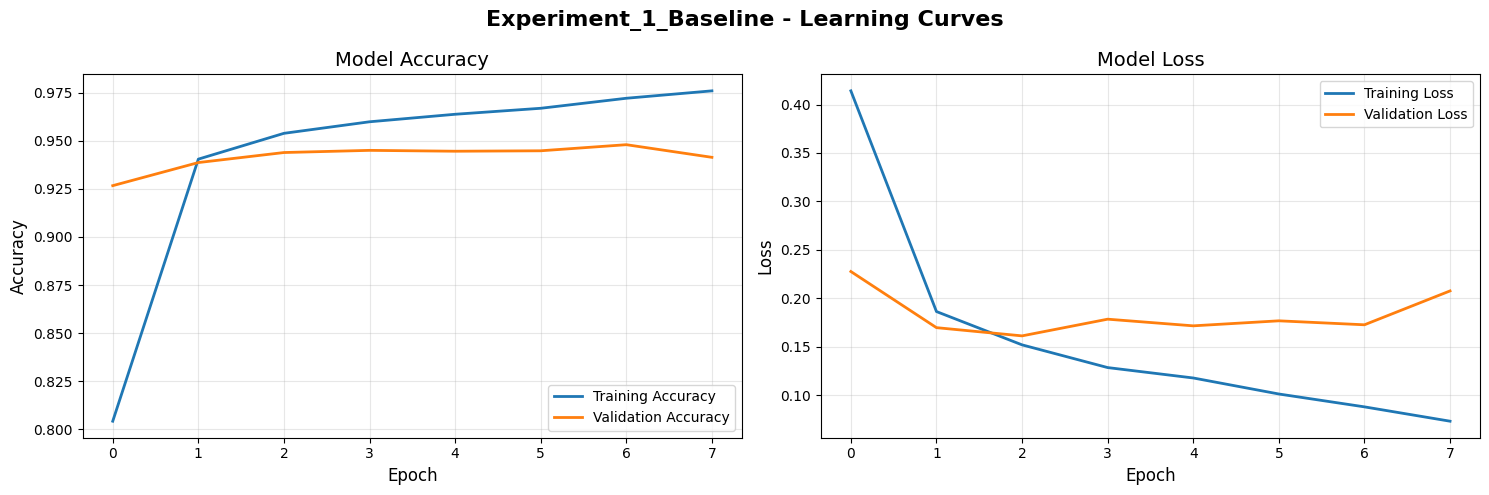

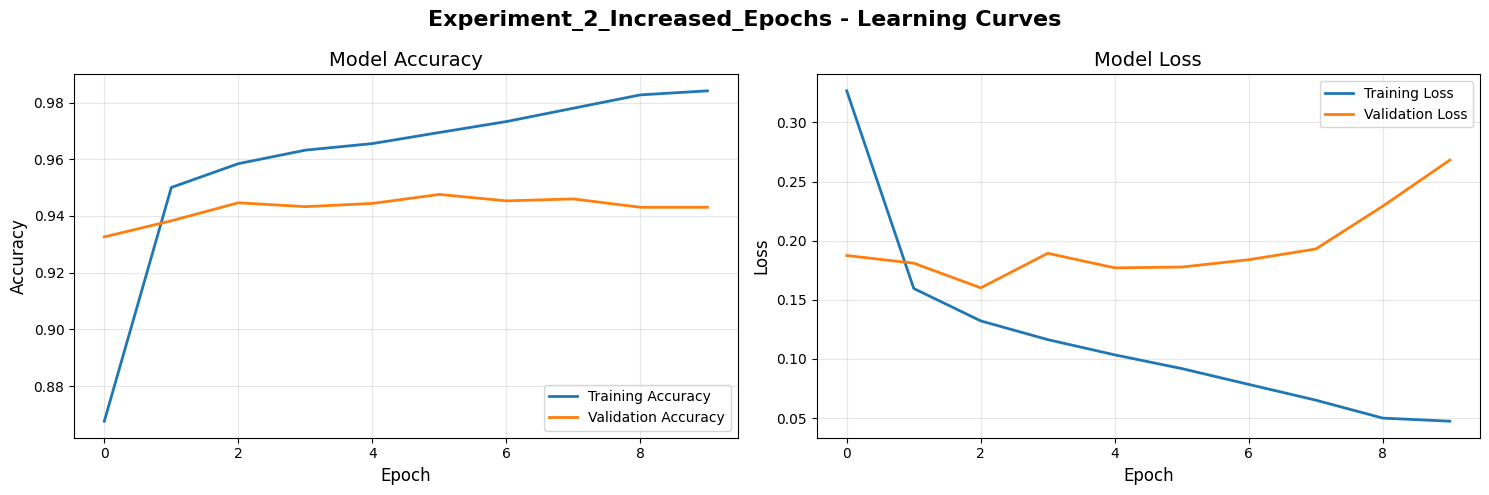

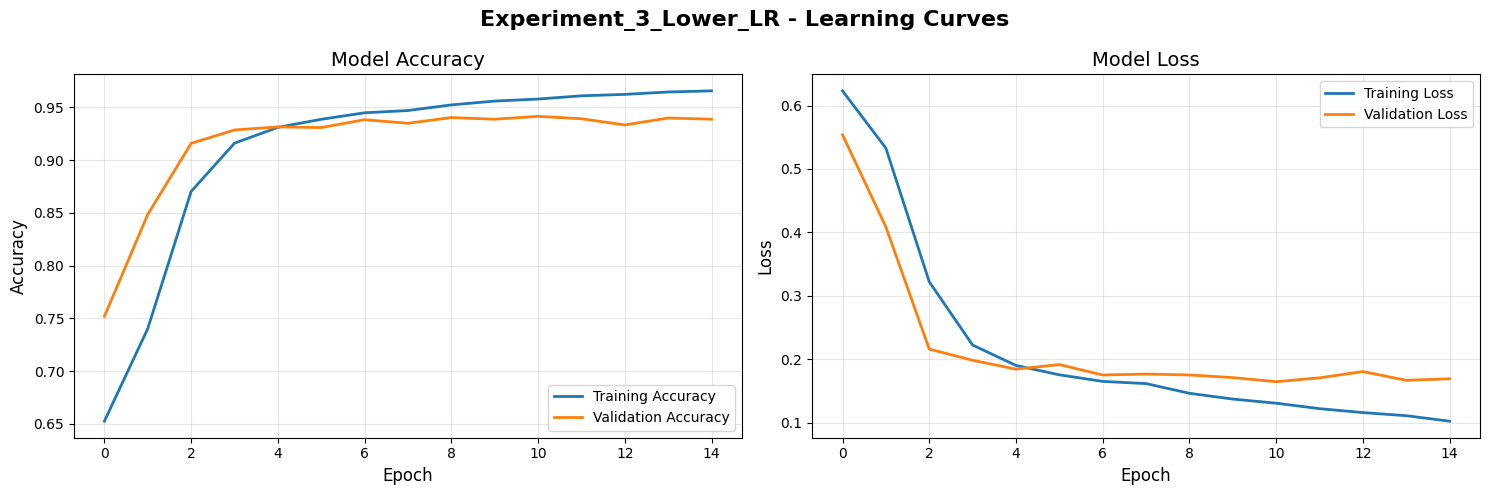

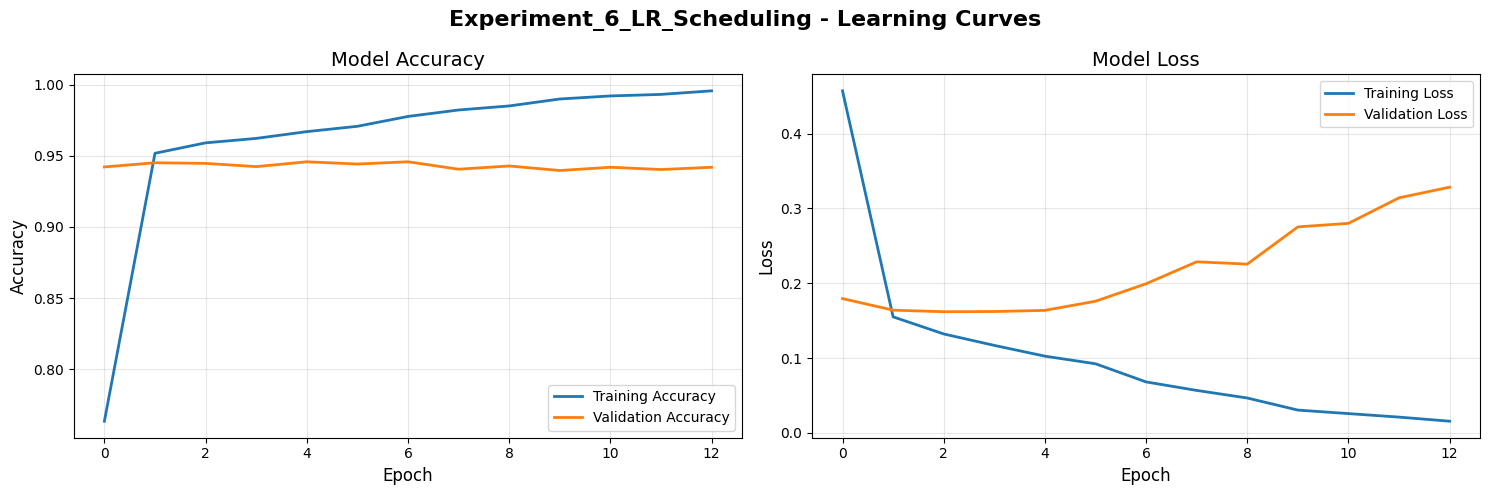

In [20]:
# ============================================================================
# SECTION 6: VISUALIZATION - LEARNING CURVES
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING LEARNING CURVES")
print("=" * 80)

def plot_learning_curves(history, experiment_name):
    """
    Plot training and validation accuracy and loss.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'{experiment_name} - Learning Curves', fontsize=16, fontweight='bold')

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy', fontsize=14)
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].set_title('Model Loss', fontsize=14)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{experiment_name}_learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot learning curves for all experiments
plot_learning_curves(history_exp1, 'Experiment_1_Baseline')
plot_learning_curves(history_exp2, 'Experiment_2_Increased_Epochs')
plot_learning_curves(history_exp3, 'Experiment_3_Lower_LR')
plot_learning_curves(history_exp6, 'Experiment_6_LR_Scheduling')

## Section 7: Confusion Matrix And Classification Report


GENERATING CONFUSION MATRIX AND CLASSIFICATION REPORT

Best performing experiment: Experiment 5
Description: Reduced dropout (15 epochs, bs=32, dropout=0.3)
Test Accuracy: 0.9577

Generating visualizations for Experiment_5_Reduced_Dropout...
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step


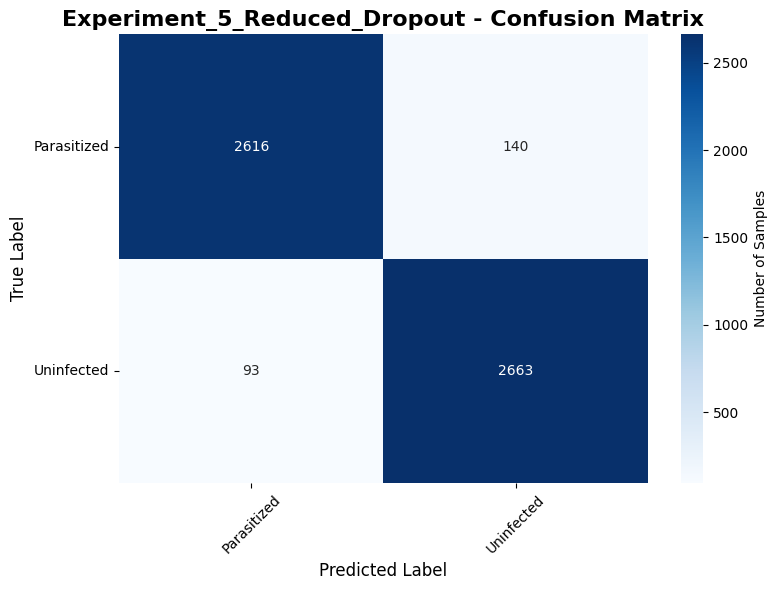


Classification Report for Experiment_5_Reduced_Dropout:
------------------------------------------------------------
              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2756
  Uninfected       0.95      0.97      0.96      2756

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512

173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step


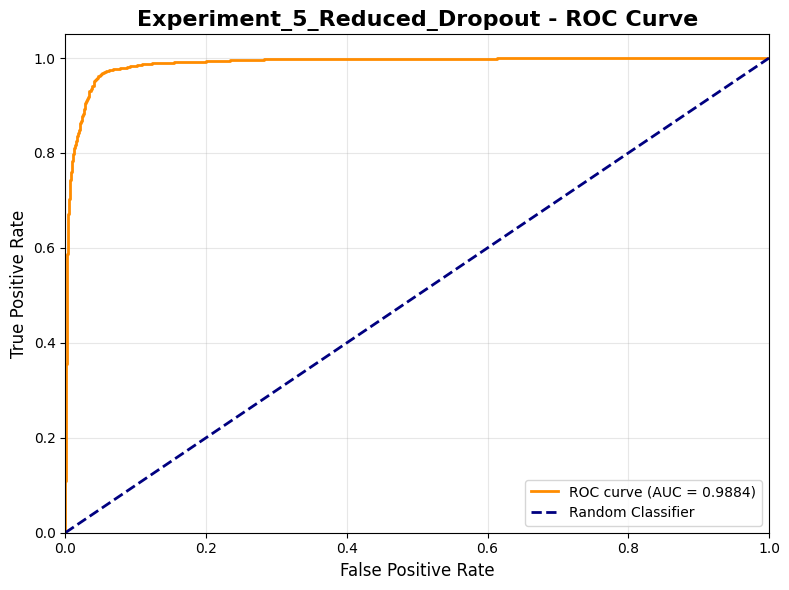


ROC AUC Score: 0.9884

COMPARATIVE ANALYSIS OF ALL EXPERIMENTS


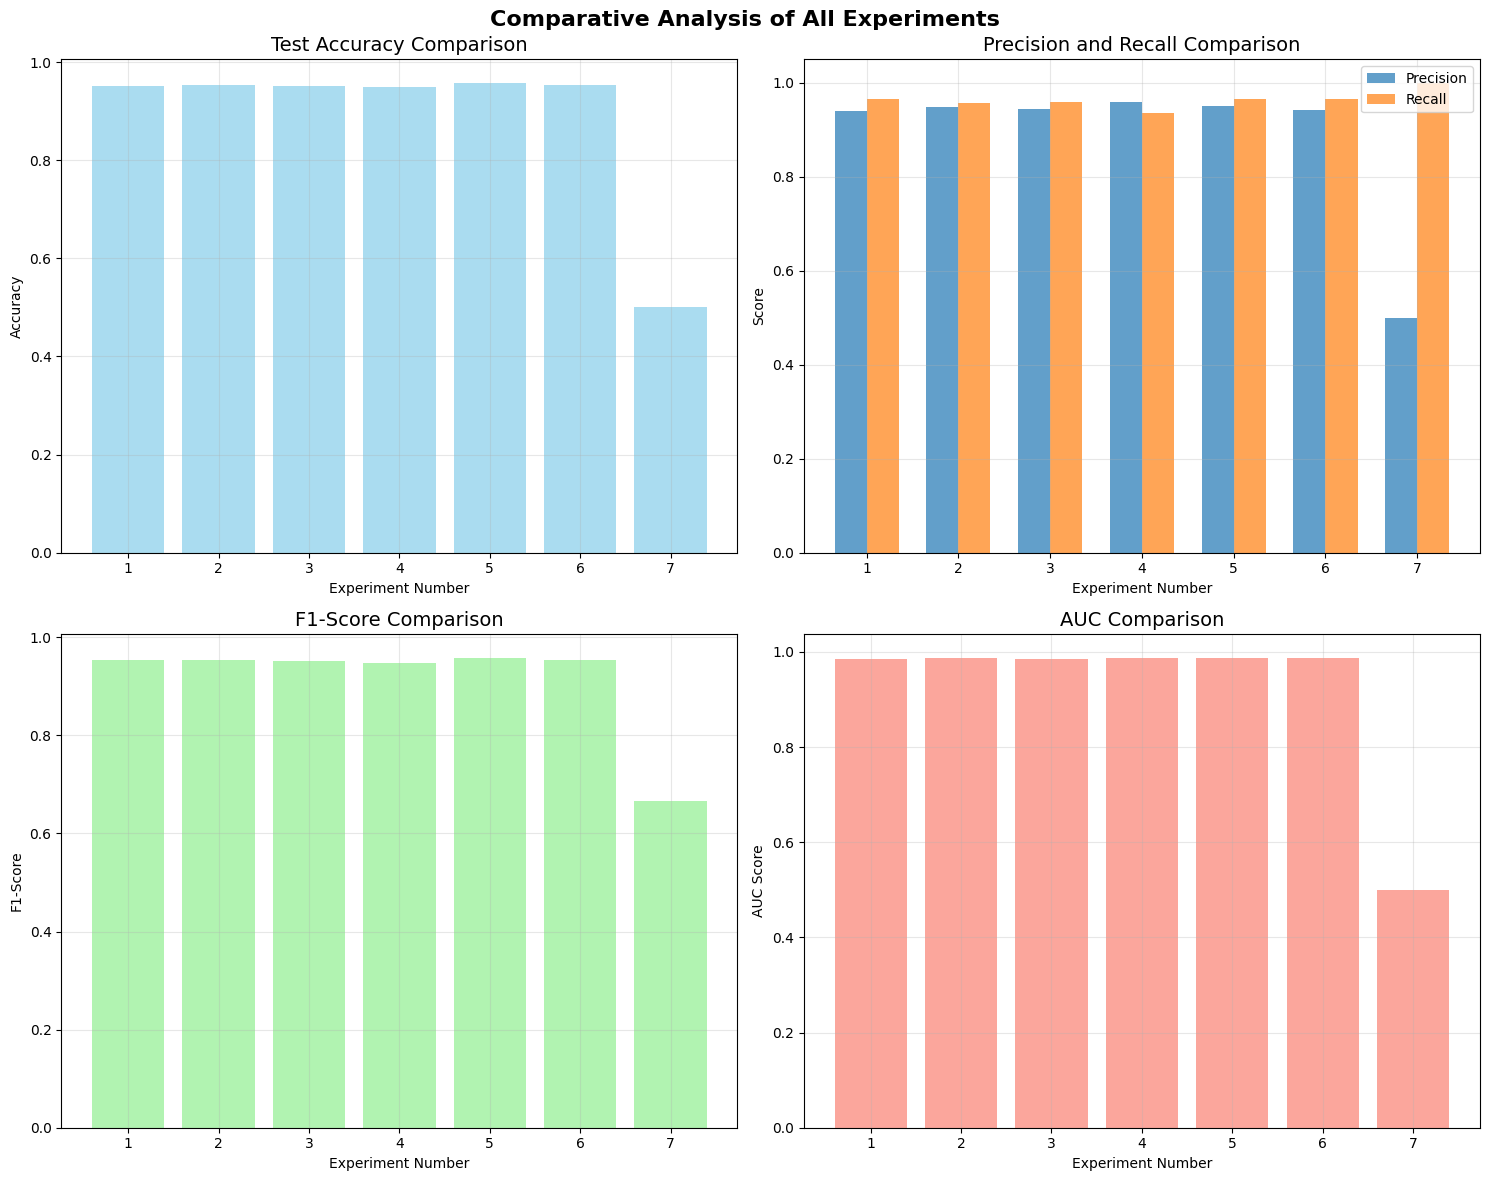


BEST EXPERIMENT SUMMARY
Experiment: 5 - Reduced dropout (15 epochs, bs=32, dropout=0.3)
Test Accuracy: 0.9577
Test Precision: 0.9501
Test Recall: 0.9663
Test F1-Score: 0.9581
Test AUC: 0.9868

BASELINE CNN IMPLEMENTATION COMPLETED!


In [23]:
# ============================================================================
# 7.3 CONFUSION MATRIX AND CLASSIFICATION REPORT
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING CONFUSION MATRIX AND CLASSIFICATION REPORT")
print("=" * 80)

def plot_confusion_matrix(model, test_generator, experiment_name):
    """
    Generate and plot confusion matrix.
    """
    # Reset the test generator to ensure proper ordering
    test_generator.reset()

    # Get predictions
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = test_generator.classes

    # Get class labels
    class_labels = list(test_generator.class_indices.keys())

    # Compute confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Number of Samples'})

    plt.title(f'{experiment_name} - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig(f'{experiment_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print classification report
    print(f"\nClassification Report for {experiment_name}:")
    print("-" * 60)
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    return cm, predictions

def plot_roc_curve(model, test_generator, experiment_name):
    """
    Generate and plot ROC curve.
    """
    # Reset the test generator
    test_generator.reset()

    # Get predictions
    predictions = model.predict(test_generator, verbose=1)
    true_classes = test_generator.classes

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(true_classes, predictions)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{experiment_name} - ROC Curve', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{experiment_name}_roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fpr, tpr, roc_auc

# Generate visualizations for the best performing experiment
# First, let's identify the best experiment based on test accuracy
best_exp_idx = df_results['Test Accuracy'].idxmax()
best_exp_num = df_results.loc[best_exp_idx, 'Experiment']
best_exp_desc = df_results.loc[best_exp_idx, 'Description']

print(f"\nBest performing experiment: Experiment {best_exp_num}")
print(f"Description: {best_exp_desc}")
print(f"Test Accuracy: {df_results.loc[best_exp_idx, 'Test Accuracy']:.4f}")

# Map experiment numbers to their corresponding models and histories
experiment_models = {
    1: (baseline_model, history_exp1, 'Experiment_1_Baseline'),
    2: (baseline_model_exp2, history_exp2, 'Experiment_2_Increased_Epochs'),
    3: (baseline_model_exp3, history_exp3, 'Experiment_3_Lower_LR'),
    4: (baseline_model_exp4, history_exp4, 'Experiment_4_Larger_Batch'),
    5: (baseline_model_exp5, history_exp5, 'Experiment_5_Reduced_Dropout'),
    6: (baseline_model_exp6, history_exp6, 'Experiment_6_LR_Scheduling'),
    7: (baseline_model_exp7, history_exp7, 'Experiment_7_Higher_LR')
}

# Generate confusion matrix and ROC curve for the best experiment
best_model, best_history, best_exp_name = experiment_models[best_exp_num]

print(f"\nGenerating visualizations for {best_exp_name}...")

# Confusion Matrix
cm, predictions = plot_confusion_matrix(best_model, test_generator, best_exp_name)

# ROC Curve
fpr, tpr, roc_auc = plot_roc_curve(best_model, test_generator, best_exp_name)

print(f"\nROC AUC Score: {roc_auc:.4f}")

# ============================================================================
# 7.4 COMPARATIVE ANALYSIS OF ALL EXPERIMENTS
# ============================================================================

print("\n" + "=" * 80)
print("COMPARATIVE ANALYSIS OF ALL EXPERIMENTS")
print("=" * 80)

# Create a comparative visualization of all experiments
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparative Analysis of All Experiments', fontsize=16, fontweight='bold')

# Accuracy comparison
axes[0, 0].bar(df_results['Experiment'], df_results['Test Accuracy'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('Test Accuracy Comparison', fontsize=14)
axes[0, 0].set_xlabel('Experiment Number')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall comparison
x_pos = np.arange(len(df_results))
width = 0.35
axes[0, 1].bar(x_pos - width/2, df_results['Test Precision'], width, label='Precision', alpha=0.7)
axes[0, 1].bar(x_pos + width/2, df_results['Test Recall'], width, label='Recall', alpha=0.7)
axes[0, 1].set_title('Precision and Recall Comparison', fontsize=14)
axes[0, 1].set_xlabel('Experiment Number')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(df_results['Experiment'])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# F1-Score comparison
axes[1, 0].bar(df_results['Experiment'], df_results['Test F1-Score'], color='lightgreen', alpha=0.7)
axes[1, 0].set_title('F1-Score Comparison', fontsize=14)
axes[1, 0].set_xlabel('Experiment Number')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].grid(True, alpha=0.3)

# AUC comparison
axes[1, 1].bar(df_results['Experiment'], df_results['Test AUC'], color='salmon', alpha=0.7)
axes[1, 1].set_title('AUC Comparison', fontsize=14)
axes[1, 1].set_xlabel('Experiment Number')
axes[1, 1].set_ylabel('AUC Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('all_experiments_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary of best experiment
print("\n" + "=" * 80)
print("BEST EXPERIMENT SUMMARY")
print("=" * 80)
print(f"Experiment: {best_exp_num} - {best_exp_desc}")
print(f"Test Accuracy: {df_results.loc[best_exp_idx, 'Test Accuracy']:.4f}")
print(f"Test Precision: {df_results.loc[best_exp_idx, 'Test Precision']:.4f}")
print(f"Test Recall: {df_results.loc[best_exp_idx, 'Test Recall']:.4f}")
print(f"Test F1-Score: {df_results.loc[best_exp_idx, 'Test F1-Score']:.4f}")
print(f"Test AUC: {df_results.loc[best_exp_idx, 'Test AUC']:.4f}")

print("\n" + "=" * 80)
print("BASELINE CNN IMPLEMENTATION COMPLETED!")
print("=" * 80)